Prime candidate: [ 79.95  92.1  100.  ]
Prime candidate details:
edu_institute                                                로이문화예술실용전문학교
average_result                                                        1.0
positive_count                                                       31.0
star                                                                 92.1
emp                                                                 100.0
final_weighted_score                                                79.95
all_reviews             주말 온종일 할만큼 재밌고 행복했어요 너무 재미있는 수업이었어요 친절하고 열정적으로...
Name: 498, dtype: object
Best candidates details:
     edu_institute  average_result  positive_count    star    emp  \
498   로이문화예술실용전문학교            1.00           31.00   92.10  100.0   
114        감미화미용학원            1.00            5.00  100.00   91.7   
67    4세대아카데미컴퓨터학원            1.00            9.00   94.20  100.0   
1101     이상인배관용접학원            1.00            3.00   97.97   92.0   
699       상주미용전문학원    

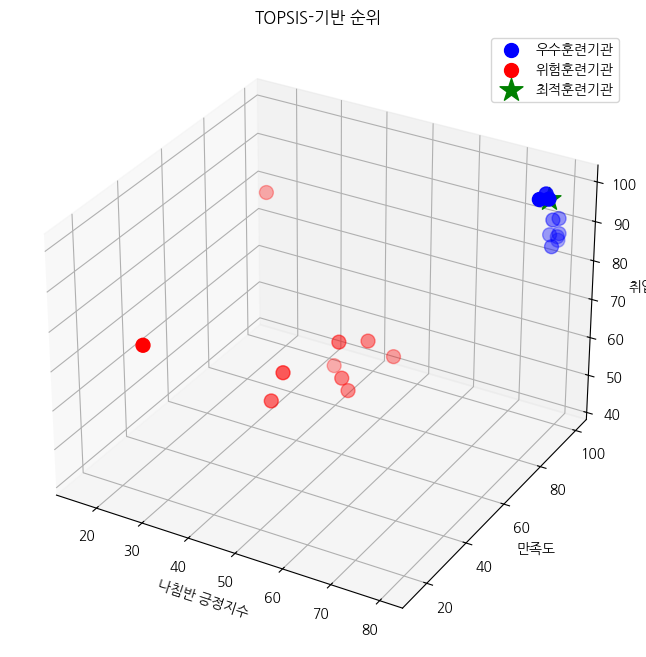

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import json
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.font_manager as fm
import os

# JSON 파일 읽기
with open('./mnt/data/weight_result.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# JSON 데이터를 데이터프레임으로 변환
df = pd.DataFrame(data)

# 정규화할 열 리스트 (문자열 열 제외)
numeric_columns = ['final_weighted_score', 'star', 'emp']

# 데이터 타입 변환 (숫자형으로 변환)
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# 결측값 확인 및 처리 (필요한 경우)
df = df.dropna(subset=numeric_columns)

# TOPSIS 알고리즘 구현
def topsis(df, weights):
    # Step 1: Normalize the data
    scaler = MinMaxScaler()
    normalized_df = scaler.fit_transform(df[numeric_columns])  # 정규화할 열만 선택

    # Step 2: Apply weights
    weighted_df = normalized_df * weights

    # Step 3: Identify ideal and anti-ideal solutions
    ideal_solution = np.max(weighted_df, axis=0)
    anti_ideal_solution = np.min(weighted_df, axis=0)

    # Step 4: Calculate the distance to the ideal and anti-ideal solutions
    distance_to_ideal = np.sqrt(np.sum((weighted_df - ideal_solution) ** 2, axis=1))
    distance_to_anti_ideal = np.sqrt(np.sum((weighted_df - anti_ideal_solution) ** 2, axis=1))

    # Step 5: Calculate the similarity to the ideal solution
    similarity_to_ideal = distance_to_anti_ideal / (distance_to_ideal + distance_to_anti_ideal)

    # Step 6: Rank the solutions
    ranking = np.argsort(similarity_to_ideal)[::-1]
    return ranking, similarity_to_ideal,normalized_df

# 데이터가 비어 있는지 확인
if df.empty:
    print("No data fetched from the database.")
else:
    # DataFrame을 numpy 배열로 변환하여 후보자 데이터 준비
    candidates = df[numeric_columns].values

    # 가중치 설정 (예: 각 지표의 가중치)
    weights = np.array([0.4, 0.3, 0.3])

    # TOPSIS 알고리즘 적용
    ranking, similarity_to_ideal = topsis(df, weights)

    # 베스트 후보와 워스트 후보 선택
    best_candidates = candidates[ranking[:10]]  # 예: 상위 10개 후보 선택
    worst_candidates = candidates[ranking[-10:]]  # 예: 하위 10개 후보 선택
    best_indices = ranking[:10]
    worst_indices = ranking[-10:]

    # 최적의 후보 데이터 출력
    prime_candidate_idx = best_indices[0]
    prime_candidate = candidates[prime_candidate_idx]
    print(f"Prime candidate: {prime_candidate}")

    # 순위를 매긴 최종 결과를 준비
    ranked_best_candidates = [{"rank": i+1, **df.iloc[best_indices[i]].to_dict()} for i in range(len(best_candidates))]
    ranked_worst_candidates = [{"rank": len(worst_candidates) - i, **df.iloc[worst_indices[i]].to_dict()} for i in range(len(worst_candidates))]

    # 최적의 후보와 베스트 후보 데이터 출력
    prime_candidate_df = df.iloc[prime_candidate_idx]
    best_candidates_df = df.iloc[best_indices]
    worst_candidates_df = df.iloc[worst_indices]

    # 각 점에 해당하는 데이터를 출력
    print(f"Prime candidate details:\n{prime_candidate_df}")
    print(f"Best candidates details:\n{best_candidates_df}")
    print(f"Worst candidates details:\n{worst_candidates_df}")

    # JSON으로 변환하여 저장
    result_data = {
        "prime_candidate": {"rank": 1, **prime_candidate_df.to_dict()},
        "ranked_best_candidates": ranked_best_candidates,
        "ranked_worst_candidates": ranked_worst_candidates
    }

    with open('topsis_result.json', 'w', encoding='utf-8') as f:
        json.dump(result_data, f, ensure_ascii=False, indent=4)

    # 결과를 CSV 파일로 저장
    prime_candidate_df.to_frame().T.to_csv('prime_candidate.csv', index=False, encoding='utf-8')
    best_candidates_df.to_csv('best_candidates.csv', index=False, encoding='utf-8')
    worst_candidates_df.to_csv('worst_candidates.csv', index=False, encoding='utf-8')

    # 폰트 파일 경로 설정
    font_location = os.path.abspath('C:/font/nanum-all/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf')

    # 폰트를 직접 로드하여 추가
    font_prop = fm.FontProperties(fname=font_location)

    # 폰트 이름 얻기
    font_name = font_prop.get_name()
    print(f"폰트다 뇬석아: {font_name}")  # 폰트 이름 출력하여 확인
    fm.fontManager.addfont(font_location)

    # matplotlib에 폰트 설정
    plt.rcParams['font.family'] = font_name

    # 시각화 (3차원 산점도)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 베스트 후보 표시
    ax.scatter(best_candidates[:, 0], best_candidates[:, 1], best_candidates[:, 2], c='blue', marker='o', s=100, label='우수훈련기관')

    # 워스트 후보 표시
    ax.scatter(worst_candidates[:, 0], worst_candidates[:, 1], worst_candidates[:, 2], c='red', marker='o', s=100, label='위험훈련기관')

    # 최적의 후보 표시 (별 모양으로 표시, 크기 더 크게)
    ax.scatter(prime_candidate[0], prime_candidate[1], prime_candidate[2], c='green', marker='*', s=300, label='최적훈련기관')

    # 축 레이블과 제목 설정
    ax.set_xlabel('나침반 긍정지수')
    ax.set_ylabel('만족도')
    ax.set_zlabel('취업률')
    ax.set_title('TOPSIS-기반 순위')

    # 범례 추가
    ax.legend()

    # 그리드 추가
    ax.grid(True)

    # 그래프 출력
    plt.show()
